In [1]:
from sklearn.datasets import load_boston
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

In [6]:
boston = load_boston()

In [8]:
# print(boston.keys())
df = pd.DataFrame(boston.data,columns=boston.feature_names)
df.head().transpose()

,0,1,2,3,4
CRIM,0.00632,0.02731,0.02729,0.03237,0.06905
ZN,18.00000,0.00000,0.00000,0.00000,0.00000
INDUS,2.31000,7.07000,7.07000,2.18000,2.18000
CHAS,0.00000,0.00000,0.00000,0.00000,0.00000
NOX,0.53800,0.46900,0.46900,0.45800,0.45800
RM,6.57500,6.42100,7.18500,6.99800,7.14700
AGE,65.20000,78.90000,61.10000,45.80000,54.20000
DIS,4.09000,4.96710,4.96710,6.06220,6.06220
RAD,1.00000,2.00000,2.00000,3.00000,3.00000
TAX,296.00000,242.00000,242.00000,222.00000,222.00000


Add the target column

In [9]:
df['PRICE'] = boston.target

Save the data to binary file so that we don't have to run the above everytime

In [10]:
df.to_feather('./raw_binary')

In [11]:
df = pd.read_feather('./raw_binary')
df.head().transpose()

,0,1,2,3,4
CRIM,0.00632,0.02731,0.02729,0.03237,0.06905
ZN,18.00000,0.00000,0.00000,0.00000,0.00000
INDUS,2.31000,7.07000,7.07000,2.18000,2.18000
CHAS,0.00000,0.00000,0.00000,0.00000,0.00000
NOX,0.53800,0.46900,0.46900,0.45800,0.45800
RM,6.57500,6.42100,7.18500,6.99800,7.14700
AGE,65.20000,78.90000,61.10000,45.80000,54.20000
DIS,4.09000,4.96710,4.96710,6.06220,6.06220
RAD,1.00000,2.00000,2.00000,3.00000,3.00000
TAX,296.00000,242.00000,242.00000,222.00000,222.00000


In [39]:
X, y = df.iloc[:,:-1],df.loc[:,'PRICE']
data_Dmatrix = xgb.DMatrix(data = X, label = y)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state = 42)
reg_xgb = xgb.XGBRegressor(max_depth=5, n_estimators=10, alpha=10, colsample_bytree=0.3)
reg_xgb.fit(X_train, y_train)
preds = reg_xgb.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test,preds))
print(rmse)

9.357383910282675


Use xgboost's CV() function to do cross validation by watching a certain specified metric, in this case rmse

In [41]:
params = {'max_depth':5, 'n_estimators':10, 'alpha':10, 'colsample_bytree':0.3}
cv_results = xgb.cv(params, data_Dmatrix, metrics = "rmse", early_stopping_rounds=10, num_boost_round=50)

[16:05:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[16:05:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[16:05:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[16:05:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[16:05:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[16:05:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[16:05:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=4
[16:05:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=5
[16:05:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=

In [45]:
cv_results.head()

,test-rmse-mean,test-rmse-std,train-rmse-mean,train-rmse-std
0,17.254588,0.694833,17.267653,0.246897
1,12.870834,0.570462,12.918997,0.381671
2,9.791178,0.505099,9.801491,0.414081
3,8.072890,0.513335,7.847970,0.430275
4,6.570891,0.598255,6.188657,0.304885


In [46]:
print("RMSE after CV: %f" % (cv_results.iloc[-1,0]))

RMSE after CV: 3.691889


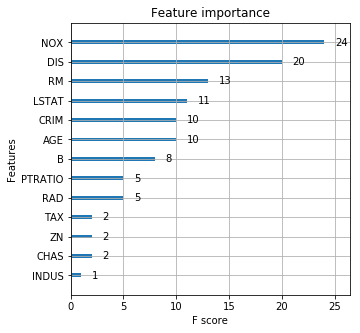

In [50]:
xgb.plot_importance(reg_xgb)
plt.rcParams['figure.figsize'] = [5, 5]
plt.show()